<center><h2 style='color:red'>MoA | Keras [NewBaseLine] with Features Engineering<br>Smoothing Vs Non-Smoothing</h2></center><hr>

## Model Based on: <a href='https://www.kaggle.com/elcaiseri/moa-keras-multilabel-classifier-nn-starter'>MoA | Keras Multilabel Classifier NN | Starter </a> Kernel.


### What is new in this Kernel?
 1. Features Engineering, and it contains:
- 3 SKlearn preprocessing scaler
- Apply Rank Gauss.
- PCA
- SVD <== NEW

 2. Feature Selection:
- VarianceThreshold

 3. Clean Data:
- Mapping Data
- drop train['cp_type'] column

 4. Model:
- using LeakyReLU rather than 'relu'
- Add model smoothing
 
* Initialize Dense Layers with "VarianceScaling" / "TruncatedNormal" ==> ' https://keras.io/api/layers/initializers/ '
* Monitor the loss without smoothing as well and Plot the results. (From @imeintanis comment on V5)

<hr><h4>Pls <span style='color:red'>UPVOTE</span>, if you find it useful. Feedbacks is also very much appreciated.<h4>

In [1]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_addons as tfa

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn import preprocessing

from sklearn.decomposition import PCA, TruncatedSVD

from tqdm.notebook import tqdm

import math

In [4]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')

data = train_features.append(test_features)

ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [5]:
import random, os, torch
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

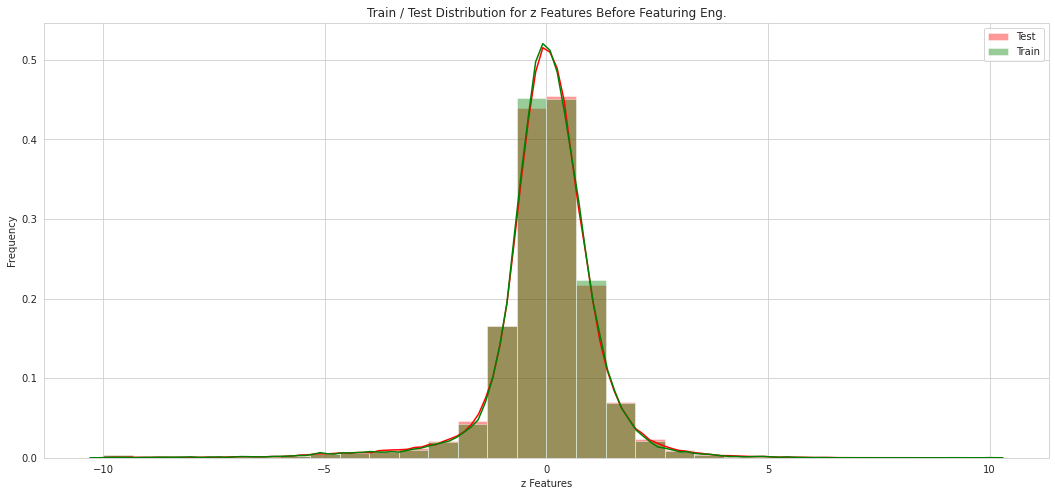

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
z= np.random.randint(0, 100, size=10)

sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))
sns.distplot(train_features.iloc[:, z], bins=30, color='red', label='Test')
sns.distplot(test_features.iloc[:, z], bins=30, color='green', label='Train')
plt.legend()
plt.title('Train / Test Distribution for z Features Before Featuring Eng.')
plt.xlabel('z Features')
plt.ylabel('Frequency')
plt.show()

In [7]:
def scaling_ss(train, test):
    features = train.columns[4:]
    scaler = preprocessing.StandardScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features

#train_features, test_features, features = scaling_ss(train_features, test_features)

In [8]:
def scaling_mm(train, test):
    features = train.columns[2:]
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features

#train_features, test_features, features = scaling_mm(train_features, test_features)

In [9]:
def scaling_rs(train, test):
    features = train.columns[4:]
    scaler = preprocessing.RobustScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features

train_features, test_features, features = scaling_rs(train_features, test_features)

In [10]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [11]:
#RankGauss
for col in (GENES + CELLS):
    transformer = QuantileTransformer(n_quantiles=206,random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [12]:
# GENES PCA
n_comp = 600  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [13]:
#CELLS PCA
n_comp = 60  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [14]:
# GENES SVD
n_comp = 450  #<--Update

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (TruncatedSVD(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'svd_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'svd_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [15]:
#CELLS SVD
n_comp = 45  #<--Update

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (TruncatedSVD(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'svd_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'svd_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [16]:
def c_squared(train, test):
    
    features_c = list(train.columns[776:876])
    for df in [train, test]:
        for feature in features_c:
            df[f'{feature}_squared'] = df[feature] ** 2
    return train, test

train_features,test_features=c_squared(train_features,test_features)

In [17]:
def c_cubed(train, test):
    
    features_c = list(train.columns[776:876])
    for df in [train, test]:
        for feature in features_c:
            df[f'{feature}_cubed'] = df[feature] ** 3
    return train, test

train_features,test_features=c_cubed(train_features,test_features)

In [18]:
def c_sqrt(train, test):
    
    features_c = list(train.columns[776:876])
    for df in [train, test]:
        for feature in features_c:
            df[f'{feature}_sqrt'] = df[feature] ** 0.5
    return train, test

train_features,test_features=c_cubed(train_features,test_features)

In [19]:
def scaling_rs(train, test):
    features = train.columns[4:]
    scaler = preprocessing.RobustScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features

#train_features, test_features, features = scaling_rs(train_features, test_features)

In [20]:
print(f'New Train/Test Features Dataset Contains [{train_features.shape[1]}] Features.')

New Train/Test Features Dataset Contains [2231] Features.


In [21]:
train_features

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90_cubed,c-91_cubed,c-92_cubed,c-93_cubed,c-94_cubed,c-95_cubed,c-96_cubed,c-97_cubed,c-98_cubed,c-99_cubed
0,id_000644bb2,trt_cp,24,D1,1.135103,0.907436,-0.416008,-0.967519,-0.255730,-1.015957,...,0.069161,4.865807e-02,2.155783,0.584040,-0.013753,1.066103,-0.124268,0.032035,0.162381,0.264380
1,id_000779bfc,trt_cp,72,D1,0.119433,0.682081,0.272778,0.080296,1.204406,0.685582,...,-0.141578,1.432816e+00,0.367403,0.000157,0.069037,0.412169,0.009312,0.005835,0.781389,1.582357
2,id_000a6266a,trt_cp,48,D1,0.780157,0.946230,1.424050,-0.131333,-0.006114,1.493094,...,-0.572840,-4.057363e-01,0.865803,0.000149,-1.791560,-0.061731,-0.435982,-0.021400,-1.415513,1.295818
3,id_0015fd391,trt_cp,48,D1,-0.735169,-0.274484,-0.438089,0.759212,2.437314,-0.859270,...,-2.874613,-4.306504e-01,-4.489882,-1.964331,-0.849592,-1.876533,-2.327340,-0.933232,-0.113975,-0.765368
4,id_001626bd3,trt_cp,72,D2,-0.451454,-0.476620,0.972982,0.971205,1.464785,-0.870063,...,0.000006,2.183535e-08,1.164409,4.760481,0.505106,-0.054272,0.003713,0.079276,-0.106784,1.407631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.208628,-0.022182,-0.236364,-0.796853,-0.675458,0.918140,...,0.021201,3.334056e-05,-0.667344,0.131904,0.463400,-0.065515,0.000739,2.976468,0.478877,0.377863
23810,id_fffb70c0c,trt_cp,24,D2,-1.909181,0.585852,-0.588143,1.295925,-1.003563,0.850510,...,0.249330,2.707209e-01,0.000373,-0.058716,-0.733980,-1.134132,-0.019825,-0.003515,-0.045690,0.181156
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.526208,0.631670,0.288170,-1.140025,0.768023,0.000584,...,0.519739,1.610694e-01,1.595723,0.072411,0.195422,0.991798,0.031522,1.593636,1.063228,0.201640
23812,id_fffcb9e7c,trt_cp,24,D1,0.817364,0.417361,0.433126,0.300989,1.070501,-0.023311,...,-0.002338,2.404564e-01,-0.015652,0.011828,10.735543,1.339387,0.013784,1.251610,-0.347243,0.002419


In [22]:
threshold = 0.9
var_thresh = VarianceThreshold(threshold)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]

train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

In [23]:
print(f'Variance Threshold Select [{train_features.shape[1]}] Features From [1836]]')

Variance Threshold Select [1360] Features From [1836]]


In [24]:
train = train_features.copy()
target = train_targets.copy()
test = test_features.copy()

target = target[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
target.drop(['sig_id'], axis=1, inplace=True)

train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
train.drop(['sig_id', 'cp_type'], axis=1, inplace=True)

test.drop(['sig_id', 'cp_type'], axis=1, inplace=True)

In [25]:
train, test, features = scaling_mm(train, test)

In [26]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    #df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})    
    df = pd.get_dummies(df, columns=['cp_time','cp_dose'])
    return df

train = preprocess(train)
test = preprocess(test)
data = train.append(test)

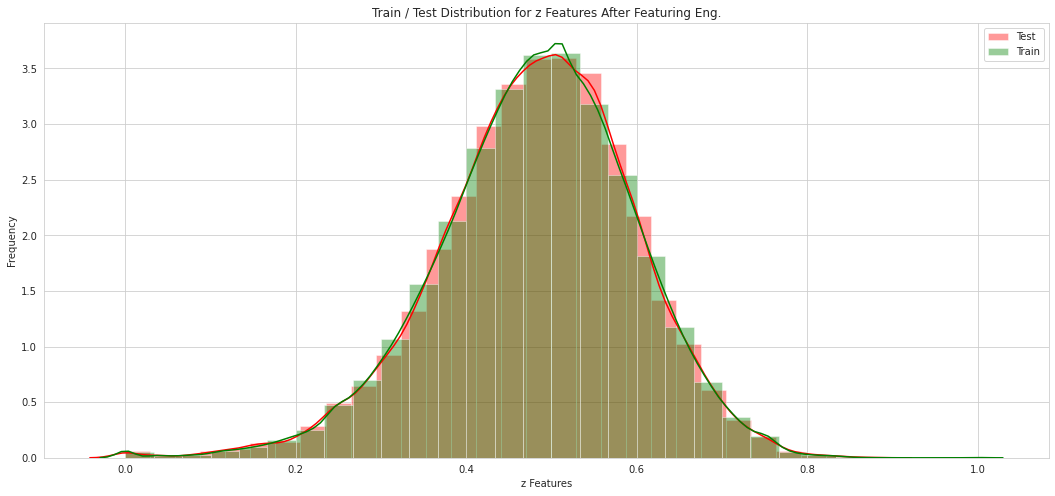

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
z= np.random.randint(0, 100, size=10)

sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))
sns.distplot(test.iloc[:, z], bins=30, color='red', label='Test')
sns.distplot(train.iloc[:, z], bins=30, color='green', label='Train')
plt.legend()
plt.title('Train / Test Distribution for z Features After Featuring Eng.')
plt.xlabel('z Features')
plt.ylabel('Frequency')
plt.show()

In [28]:
train

,0,1,2,3,4,5,6,7,8,9,...,1351,1352,1353,1354,1355,cp_time_24,cp_time_48,cp_time_72,cp_dose_0,cp_dose_1
0,0.609158,0.646440,0.308137,0.406957,0.475407,0.402299,0.368624,0.497608,0.565340,0.470140,...,0.503792,0.499558,0.500114,0.500578,0.500940,1,0,0,1,0
1,0.511485,0.622585,0.393002,0.507722,0.615823,0.565930,0.530235,0.553500,0.448345,0.580527,...,0.501466,0.500033,0.500021,0.502780,0.505629,0,0,1,1,0
2,0.575025,0.650547,0.534850,0.487370,0.499412,0.643585,0.522639,0.535048,0.499477,0.619132,...,0.499780,0.498449,0.499924,0.494965,0.504610,0,1,0,1,0
3,0.429302,0.521326,0.305417,0.573010,0.734387,0.417367,0.279287,0.529731,0.481507,0.366747,...,0.493325,0.491721,0.496680,0.499595,0.497277,0,1,0,1,0
4,0.456585,0.499929,0.479274,0.593397,0.640863,0.416329,0.463837,0.480302,0.397645,0.581786,...,0.499807,0.500013,0.500282,0.499620,0.505007,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,0.522856,0.420212,0.386328,0.464782,0.468273,0.554743,0.485487,0.475999,0.409579,0.497097,...,0.499892,0.497788,0.507937,0.499483,0.500192,0,0,1,1,0
21944,0.520063,0.548034,0.330271,0.423370,0.435044,0.588294,0.570841,0.548845,0.440025,0.495985,...,0.499767,0.500003,0.510588,0.501704,0.501344,1,0,0,0,1
21945,0.316402,0.612398,0.286929,0.624624,0.403491,0.581790,0.470727,0.432245,0.560574,0.562117,...,0.495966,0.499929,0.499987,0.499837,0.500644,1,0,0,0,1
21946,0.578603,0.594562,0.412758,0.528945,0.602946,0.497758,0.504787,0.509578,0.551006,0.385170,...,0.504765,0.500049,0.504452,0.498765,0.500009,1,0,0,1,0


In [29]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,1351,1352,1353,1354,1355,cp_time_24,cp_time_48,cp_time_72,cp_dose_0,cp_dose_1
count,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,...,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000
mean,0.502042,0.552399,0.361450,0.499739,0.502718,0.499593,0.497230,0.500239,0.495345,0.498808,...,0.498518,0.491880,0.498543,0.497987,0.499309,0.326499,0.346364,0.327137,0.510115,0.489885
std,0.096165,0.104025,0.122198,0.095595,0.093675,0.095743,0.094417,0.094526,0.100729,0.096036,...,0.027781,0.066588,0.027803,0.032346,0.015929,0.468943,0.475822,0.469178,0.499909,0.499909
min,0.000000,0.000000,0.015459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.436963,0.482274,0.278478,0.435310,0.439490,0.434707,0.432999,0.437521,0.431393,0.433760,...,0.498728,0.498758,0.498760,0.498677,0.498729,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.501231,0.552190,0.361541,0.499457,0.501903,0.499800,0.496730,0.501495,0.495936,0.498998,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.565808,0.622842,0.444658,0.564038,0.565117,0.564250,0.560581,0.564089,0.560957,0.563868,...,0.500963,0.500992,0.500951,0.500884,0.500867,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
np.mean(train.values), np.std(train.values), np.min(train.values), np.max(train.values)

(0.4519135339258402, 0.15778916230363557, 0.0, 1.0000000000000002)

In [31]:
somthing_rate = 1e-3
P_MIN = somthing_rate
P_MAX = 1 - P_MIN

def loss_fn(yt, yp):
    yp = np.clip(yp, P_MIN, P_MAX)
    return log_loss(yt, yp, labels=[0,1])

NUM_FEATURES = train.shape[1]
NUM_FEATURES

1361

In [32]:
def create_model(num_columns, hidden_layers=1500, SEED=None):
    model = tf.keras.Sequential([tf.keras.layers.Input(num_columns)])
    #initializer = tf.keras.initializers.VarianceScaling(scale=2., mode='fan_in', distribution='truncated_normal', seed=SEED)#math.sqrt(6. / n) 
    initializer = tf.keras.initializers.TruncatedNormal(mean=0.5, stddev=1., seed=SEED) 

    model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Dropout(0.4))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(hidden_layers, kernel_initializer=initializer)))
    #model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2654321))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(hidden_layers, kernel_initializer=initializer)))
    #model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.LeakyReLU())

    #============ Final Layer =================
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2678923456789))
    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, kernel_initializer=initializer)))
    model.add(tf.keras.layers.Activation('sigmoid'))
    
    tfa_opt = tfa.optimizers.Lookahead(tfa.optimizers.AdamW(lr = 1e-2, weight_decay = 1e-5), sync_period=10)
    tf_opt = tfa.optimizers.Lookahead(tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-15), sync_period=10)
    
    model.compile(optimizer=tfa_opt, 
                  loss=BinaryCrossentropy(),
                  metrics=BinaryCrossentropy(label_smoothing=somthing_rate)
                  )
    return model

In [33]:
# Use All feats as top feats
top_feats = [i for i in range(train.shape[1])]
print("Top feats length:",len(top_feats))

Top feats length: 1361


In [34]:
mod = create_model(len(top_feats))
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1361)              5444      
_________________________________________________________________
weight_normalization (Weight (None, 1500)              4087501   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1500)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1500)              6000      
_________________________________________________________________
dropout (Dropout)            (None, 1500)              0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 1500)              4504501   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1500)              0

In [35]:
def metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(loss_fn(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float)))
    return np.mean(metrics)

In [36]:
N_STARTS = 5

train_targets = target

res = train_targets.copy()
ss.loc[:, train_targets.columns] = 0
res.loc[:, train_targets.columns] = 0

historys = dict()

#tf.random.set_seed(42)
seed_everything(seed=42)
for seed in range(N_STARTS):
    for n, (tr, te) in enumerate(MultilabelStratifiedKFold(n_splits=7, random_state=seed, shuffle=True).split(train_targets, train_targets)):
        print(f"======{train_targets.values[tr].shape}========{train_targets.values[te].shape}=====")
        print(f'Seed: {seed} => Fold: {n}')
        
        checkpoint_path = f'repeat:{seed}_Fold:{n}.hdf5'
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-20, patience=6, verbose=1, mode='min')
        cb_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose = 1, save_best_only = True,
                                     save_weights_only = True, mode = 'min')
        early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience= 14, verbose = 1)
        
        model = create_model(len(top_feats), SEED=seed)
        
        history = model.fit(train.values[tr][:, top_feats],
                  train_targets.values[tr],
                  validation_data=(train.values[te][:, top_feats], train_targets.values[te]),
                  epochs=100, batch_size=128,
                  callbacks=[reduce_lr_loss, cb_checkpt, early], verbose=2
                 )
        historys[f'history_seed_{seed+1}_fold_{n+1}'] = history
        print("Model History Saved.")
        
        model.load_weights(checkpoint_path)
        test_predict = model.predict(test.values[:, top_feats])
        val_predict = model.predict(train.values[te][:, top_feats])
        
        ss.loc[:, train_targets.columns] += test_predict
        res.loc[te, train_targets.columns] += val_predict
        
        print(f'OOF Metric For SEED {seed} => FOLD {n} : {metric(train_targets.loc[te, train_targets.columns], pd.DataFrame(val_predict, columns=train_targets.columns))}')
        print('+-' * 10)

======(18813, 206)========(3135, 206)=====
Seed: 0 => Fold: 0
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.02359, saving model to repeat:0_Fold:0.hdf5
147/147 - 2s - loss: 0.1898 - binary_crossentropy: 0.1912 - val_loss: 0.0236 - val_binary_crossentropy: 0.0262
Epoch 2/100

Epoch 00002: val_loss improved from 0.02359 to 0.02279, saving model to repeat:0_Fold:0.hdf5
147/147 - 1s - loss: 0.0213 - binary_crossentropy: 0.0240 - val_loss: 0.0228 - val_binary_crossentropy: 0.0258
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02279
147/147 - 1s - loss: 0.0201 - binary_crossentropy: 0.0231 - val_loss: 0.0231 - val_binary_crossentropy: 0.0264
Epoch 4/100

Epoch 00004: val_loss improved from 0.02279 to 0.02093, saving model to repeat:0_Fold:0.hdf5
147/147 - 1s - loss: 0.0192 - binary_crossentropy: 0.0223 - val_loss: 0.0209 - val_binary_crossentropy: 0.0243
Epoch 5/100

Epoch 00005: val_loss improved from 0.02093 to 0.02012, saving model to repeat:0_Fold:0.hdf5
147/147 - 

## Smoothing vs Non-Smoothing

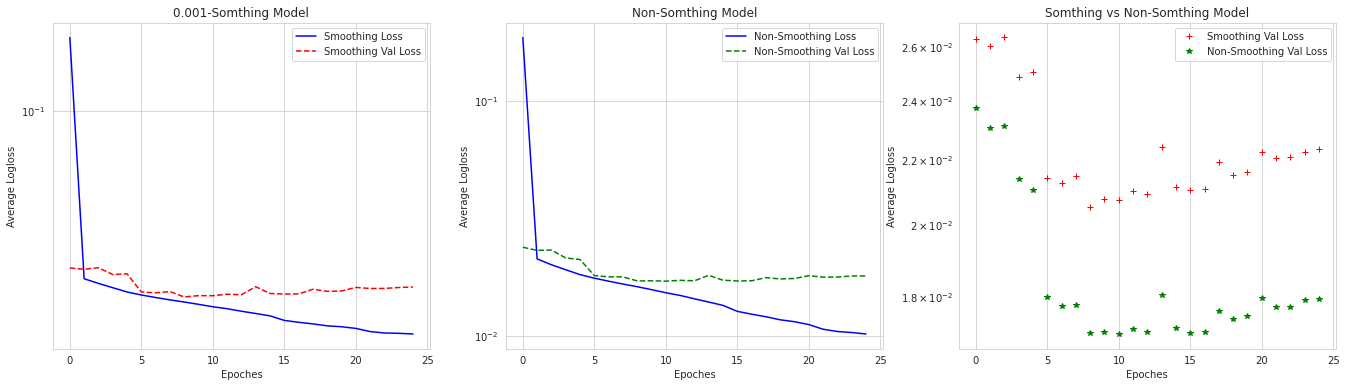

In [37]:
# Show Model loss in plots
for k,v in historys.items():
    loss = []
    val_loss = []
    loss.append(v.history['loss'][:35])
    val_loss.append(v.history['val_loss'][:35])
    
# Show Model loss in plots
for k,v in historys.items():
    bin_loss = []
    bin_val_loss = []
    bin_loss.append(v.history['binary_crossentropy'][:35])
    bin_val_loss.append(v.history['val_binary_crossentropy'][:35])
    
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize = (23, 6))

ax[0].plot(np.mean(bin_loss, axis=0), 'b', label='Smoothing Loss')
ax[0].plot(np.mean(bin_val_loss, axis=0), 'r--', label='Smoothing Val Loss')
ax[0].set(title=f'{somthing_rate}-Somthing Model', yscale='log', yticks=[1,1e-1,1e-2], xlabel='Epoches', ylabel='Average Logloss')
ax[0].legend()

ax[1].plot(np.mean(loss, axis=0), 'b', label='Non-Smoothing Loss')
ax[1].plot(np.mean(val_loss, axis=0), 'g--',label='Non-Smoothing Val Loss')
ax[1].set(title='Non-Somthing Model', yscale='log', yticks=[1,1e-1,1e-2], xlabel='Epoches', ylabel='Average Logloss')
ax[1].legend()


ax[2].plot(np.mean(bin_val_loss, axis=0), 'r+', label='Smoothing Val Loss')
ax[2].plot(np.mean(val_loss, axis=0), 'g*',label='Non-Smoothing Val Loss')
ax[2].set(title='Somthing vs Non-Somthing Model', yscale='log', xlabel='Epoches', ylabel='Average Logloss')
ax[2].legend()

In [38]:
ss.loc[:, train_targets.columns] /= ((n+1) * N_STARTS)
res.loc[:, train_targets.columns] /= N_STARTS

In [39]:
print(f'OOF Metric: {metric(train_targets, res)}')

OOF Metric: 0.016380999639954895


In [40]:
np.save('oof_keras', res)
np.save('pred_keras', ss)

ss.to_csv('submission_test.csv', index=False)

In [41]:
ss.to_csv('submission.csv', index=False)

Kernel still under modification.. **<span style='color:red'>Feedbacks</span>** is also very much appreciated.
Pls **<span style='color:red'>UPVOTE</span>**, if you find it useful. 
